Repeat of the experiment done in 

**Learning long-term dependencies with gradient descent is difficult**

https://dl.acm.org/citation.cfm?id=2328340

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.style.use('classic')

%matplotlib inline

import numpy as np

from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers import Input, LSTM, LSTMCell, Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from keras import backend as K

K.set_session(
    K.tf.Session(
        config=K.tf.ConfigProto(
            intra_op_parallelism_threads=32,
            inter_op_parallelism_threads=32)
    )
)

import tensorflow as tf
tf.__version__

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

adf = pd.read_csv('./data/info-latching/seq_len_10.csv')

# -1: not counting label column
seq_len = adf.shape[1] - 1
N = adf.shape[0]
batch_size = 100

train_xs = adf.drop('label', axis=1).values.reshape(N, seq_len, 1)

train_ys = adf.label.values

Using TensorFlow backend.


In [2]:
inputs = Input(shape=(None, 1), name='input')
rnn = LSTM(1, input_shape=(None, 1), name='rnn')
rnn_out = rnn(inputs)
dense = Dense(1, activation='sigmoid', name='output')
dense_out = dense(rnn_out)
model = Model(inputs, dense_out)
optm = Adam(lr=1e-3, clipnorm=1)
# optm = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optm, loss='mse', metrics=['accuracy'])
hist = model.fit(train_xs, train_ys,
                 batch_size=batch_size,
                 epochs=30,
                 validation_split=0.2, 
                 verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 2s 201us/step - loss: 0.2500 - acc: 0.5236 - val_loss: 0.2496 - val_acc: 0.5660
Epoch 2/30
8000/8000 [==============================] - 1s 136us/step - loss: 0.2482 - acc: 0.5150 - val_loss: 0.2446 - val_acc: 0.5205
Epoch 3/30
8000/8000 [==============================] - 1s 138us/step - loss: 0.2305 - acc: 0.5460 - val_loss: 0.2011 - val_acc: 0.8165
Epoch 4/30
8000/8000 [==============================] - 1s 136us/step - loss: 0.1568 - acc: 0.9700 - val_loss: 0.1138 - val_acc: 1.0000
Epoch 5/30
8000/8000 [==============================] - 1s 134us/step - loss: 0.0936 - acc: 0.9998 - val_loss: 0.0777 - val_acc: 1.0000
Epoch 6/30
8000/8000 [==============================] - 1s 138us/step - loss: 0.0689 - acc: 0.9996 - val_loss: 0.0607 - val_acc: 1.0000
Epoch 7/30
8000/8000 [==============================] - 1s 136us/step - loss: 0.0550 - acc: 0.9996 - val_loss: 0.0495 - val_acc: 1.0000


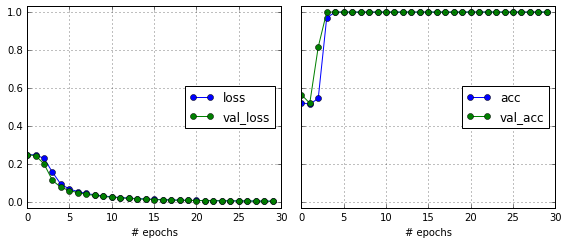

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3.5))
axes = axes.ravel()

for k, keys in enumerate([['loss', 'val_loss'], ['acc', 'val_acc']]):
    ax = axes[k]
    
    for key in keys:
        ax.plot(hist.history[key], 'o-', label=key)
    ax.grid()
    ax.legend(loc='center right')
    ax.set_ylim(-0.03, 1.03)
    ax.set_xlabel('# epochs')
plt.tight_layout()

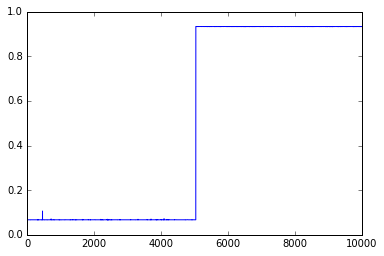

In [4]:
plt.plot(model.predict(train_xs[np.argsort(train_ys)]))

ref: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Since the input at each time step is only 1 dimension, so I used $w$ (scalar) instead of $W$ (matrix).

<img src="https://raw.githubusercontent.com/zyxue/sutton-barto-rl-exercises/master/supervised/neuron_networks/lstm.png" width=600/>

Calculate gates:

\begin{align*}
f_t &= \sigma(w_f[h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(w_i[h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(w_C[h_{t-1}, x_t] + b_C) \\
o_t &= \sigma(w_o[h_{t-1}, x_t] + b_o)
\end{align*}

Update $C_t$ and $h_t$,
\begin{align*}
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align*}

In [5]:
rnn.get_weights()

[array([[-1.4620256e+00,  3.6272305e-01,  6.8717319e-01,  4.0708703e-04]],
       dtype=float32),
 array([[-0.18914315, -0.6183619 ,  1.1779431 , -0.9139777 ]],
       dtype=float32),
 array([1.0240248 , 1.9957571 , 0.15408403, 1.5878369 ], dtype=float32)]

In [6]:
# ref: https://github.com/keras-team/keras/blob/d035967a5d2795734c89a0a3c002f7eb5c34eff1/keras/layers/recurrent.py#L1865
kernel = np.array(rnn.get_weights()[:2])[:,0,:]
kernel

array([[-1.4620256e+00,  3.6272305e-01,  6.8717319e-01,  4.0708703e-04],
       [-1.8914315e-01, -6.1836189e-01,  1.1779431e+00, -9.1397768e-01]],
      dtype=float32)

In [7]:
w_i, w_f, w_c, w_o = kernel.T
b_i, b_f, b_c, b_o = rnn.get_weights()[-1]

In [8]:
print(w_i, b_i)
print(w_f, b_f)
print(w_c, b_c)
print(w_o, b_o)

[-1.4620256  -0.18914315] 1.0240248
[ 0.36272305 -0.6183619 ] 1.9957571
[0.6871732 1.1779431] 0.15408403
[ 4.0708703e-04 -9.1397768e-01] 1.5878369


In [9]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[3.1373634] [0.506981]


In [10]:
for k, single_x in enumerate([train_xs[0], train_xs[1], train_xs[-2], train_xs[-1]]):
    h_prev = 0
    C_prev = 0

    hist = []
    for t in range(single_x.shape[0]):
    #     cat_x = [h_prev, single_x[t][0]]
        cat_x = [single_x[t][0], h_prev]
        f_t = sigmoid(np.dot(w_f, cat_x) + b_f)
        i_t = sigmoid(np.dot(w_i, cat_x) + b_i)
        B_t = np.tanh(np.dot(w_c, cat_x) + b_c) # use B to mean \tilde{C}
        o_t = sigmoid(np.dot(w_o, cat_x) + b_o)

        C_t = f_t * C_prev + i_t * B_t
        h_t = o_t * np.tanh(C_t)

        hist.append([f_t, i_t, B_t, o_t, C_t, h_t])

        h_prev = h_t
        C_prev = C_t
    den_in = hist[-1][-1]
    out = sigmoid(den_in * d_w0 + d_b0)
    print(out, model.predict(np.array([single_x])))

[0.08576471] [[0.0672553]]
[0.08578086] [[0.06725942]]
[0.08599309] [[0.06734566]]
[0.08559202] [[0.0672425]]


The mannual process and model prediction are highly correlated, but still not the same...., in constrast to simpler SimpleRNN process in another notebook.

# Single x debugging and time step visualization

In [11]:
single_x = train_xs[5]
# single_x

In [12]:
h_prev = 0
C_prev = 0

hist = []
for t in range(single_x.shape[0]):
#     cat_x = [h_prev, single_x[t][0]]
    cat_x = [single_x[t][0], h_prev]
    f_t = sigmoid(np.dot(w_f, cat_x) + b_f)
    i_t = sigmoid(np.dot(w_i, cat_x) + b_i)
    B_t = np.tanh(np.dot(w_c, cat_x) + b_c) # use B to mean \tilde{C}
    o_t = sigmoid(np.dot(w_o, cat_x) + b_o)

    C_t = f_t * C_prev + i_t * B_t
    h_t = o_t * np.tanh(C_t)

    hist.append([f_t, i_t, B_t, o_t, C_t, h_t])

    h_prev = h_t
    C_prev = C_t

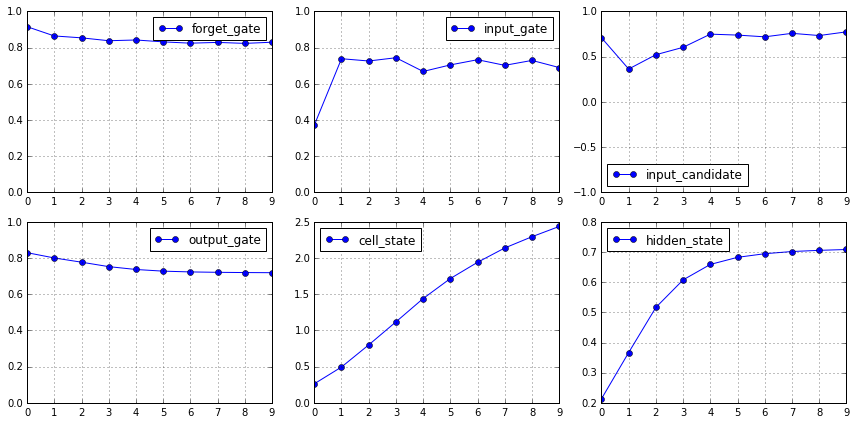

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), 
#                          sharex=True, sharey=True
                        )
axes = axes.ravel()

for k, i in enumerate([
    'forget_gate', 'input_gate', 'input_candidate', 'output_gate', 
    'cell_state', 'hidden_state'
]):
    ax = axes[k]
    ax.plot(np.array(hist)[:,k], 'o-', label=i)
    ax.legend(loc='best')
    ax.grid()
    
    if k in [0, 1, 3]:
        ax.set_ylim(0, 1)
    if k == 2:
        ax.set_ylim(-1, 1)

plt.tight_layout()

So seems that `input_candidate` are completely ignored

In [14]:
dense.get_weights()

[array([[3.1373634]], dtype=float32), array([0.506981], dtype=float32)]

In [15]:
# den_in = hist[-1][-1] # dense input
den_in = hist[-1][-1]

In [16]:
den_in

0.7087554367261066

In [17]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[3.1373634] [0.506981]


In [18]:
sigmoid(den_in * d_w0 + d_b0)

array([0.9388085], dtype=float32)

In [19]:
model.predict(np.array([single_x]))

array([[0.93307644]], dtype=float32)

Followed equations from [colah's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), but there is always inconsistency.... 